# <font color='#1a5276'> <b> <center> Optimization </center> </b> </font>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Data](#4)
5. [Model and cost function](#5)
6. [Batch Gradient Descent](#6)
7. [Stochastic Gradient Descent](#7)
8. [Mini-batch Gradient Descent](#8)
9. [References](#references)

<a name="1"></a>
## <font color='blue'> <b> 1. Introduction </b> </font>

This notebook explores the fundamentals of gradient descent optimization and its three key variations: batch, stochastic, and mini-batch gradient descent. Using PyTorch, we implement and compare these methods, analyzing their convergence behavior and efficiency on a simple problem.

<a name="2"></a>
## <font color='blue'> <b> 2. Setup </b> </font>

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits import mplot3d

In [3]:
# Set random seed
torch.manual_seed(1)

<a name="3"></a>
## <font color='blue'> <b> 3. Helper Functions </b> </font>

In [4]:
# The class for plotting the diagram
class plot_error_surfaces(object):
    
    # Constructor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        # Generate values for w and b in the given range
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        
        # Create a meshgrid of w and b values
        w, b = np.meshgrid(W, B)    
        
        # Initialize the loss surface array
        Z = np.zeros((30, 30))
        count1 = 0
        
        # Convert input data X, Y to numpy arrays
        self.y = Y.numpy()
        self.x = X.numpy()
        
        # Calculate the loss for each (w, b) pair
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                Z[count1, count2] = np.mean((self.y - w2 * self.x + b2) ** 2)  # Mean squared error
                count2 += 1
            count1 += 1
        
        # Store the results
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        
        # If plotting is enabled, show the loss surfaces
        if go == True:
            plt.figure()
            # Set figsize dynamically based on the number of samples (n_samples) for better visualization
            figsize = (n_samples * 0.25, 5)  # Adjust the width based on the number of samples
            plt.figure(figsize=figsize)
            
            # Plot the 3D surface of the loss function
            plt.axes(projection = '3d').plot_surface(self.w, self.b, self.Z, rstride = 1, cstride = 1, cmap = 'viridis', edgecolor = 'none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            
            # Plot the contour of the loss function
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
    
    # Setter to store parameters and loss values
    def set_para_loss(self, W, B, loss):
        self.n = self.n + 1
        self.W.append(W)
        self.B.append(B)
        self.LOSS.append(loss)
    
    # Plot the final 3D diagram of the loss surface
    def final_plot(self): 
        ax = plt.axes(projection = '3d')
        ax.plot_wireframe(self.w, self.b, self.Z)  # Wireframe plot
        ax.scatter(self.W, self.B, self.LOSS, c = 'r', marker = 'x', s = 200, alpha = 1)  # Scatter the points
        plt.figure()
        plt.contour(self.w, self.b, self.Z)  # Contour plot
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')  # Scatter the points
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
    
    # Plot the data space and loss surface contour for each iteration
    def plot_ps(self):
        plt.subplot(121)  # Left plot for data space
        plt.ylim
        plt.plot(self.x, self.y, 'ro', label = "training points")  # Plot the training points
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label = "estimated line")  # Plot the estimated line
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-10, 15))  # Limit y-axis for better visualization
        plt.title('Data Space Iteration: ' + str(self.n))
        
        plt.subplot(122)  # Right plot for loss surface contour
        plt.contour(self.w, self.b, self.Z)  # Contour plot
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')  # Scatter the points
        plt.title('Loss Surface Contour Iteration ' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()


<a name="4"></a>
## <font color='blue'> <b> 4. Data </b> </font>

We will create synthetic data.

In [5]:
# Setup the actual data and simulated data
X = torch.arange(-3, 3, 0.1).view(-1, 1) # view is for reshape
f = 1 * X - 1
y = f + 0.1 * torch.randn(X.size())

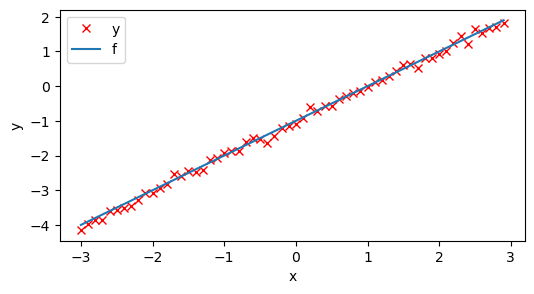

In [6]:
# Plot out the data dots and line
plt.figure(figsize=(6,3))
plt.plot(X.numpy(), y.numpy(), 'rx', label = 'y')
plt.plot(X.numpy(), f.numpy(), label = 'f')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

<a name="5"></a>
## <font color='blue'> <b> 5. Model and cost function </b> </font>

In [7]:
# Define the forward function
def forward(x, w, b):
    return w * x + b

In [8]:
# Define the MSE Loss function
def criterion(yhat, y):
    return torch.mean((yhat - y) ** 2)

<Figure size 640x480 with 0 Axes>

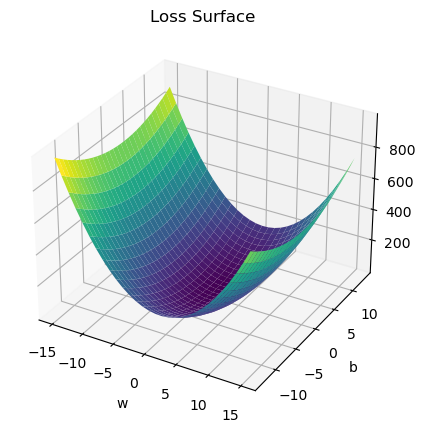

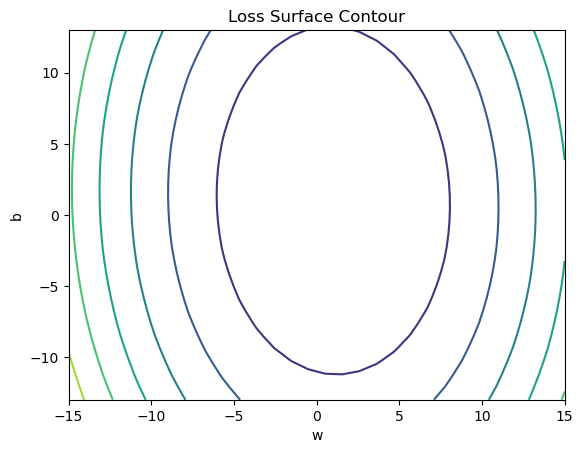

In [9]:
# Create plot_error_surfaces for viewing the data
get_surface = plot_error_surfaces(15, 13, X, y, 30)

<a name="6"></a>
## <font color='blue'> <b> 6. Batch Gradient Descent </b> </font>


Batch Gradient Descent is an optimization algorithm that computes the gradient of the cost function using the entire dataset in each iteration.

In [10]:
def train_model(iter, X, y, lr = 0.1):
    
    # Define the parameters w, b for y = wx + b (initial values)
    w = torch.tensor(-15.0, requires_grad = True)
    b = torch.tensor(-10.0, requires_grad = True)
    
    # to save the results
    loss_bgd = []
    
    # loop
    for epoch in range(iter):
        
        # make a prediction
        y_hat = forward(X, w, b)
        
        # calculate the loss
        loss = criterion(y_hat, y)
        
        # plotting
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
        get_surface.plot_ps()
    
        # store the loss in the list loss_bgd
        loss_bgd.append(loss)
        
        # backward pass: compute gradient of the loss with respect to all the learnable parameters
        loss.backward()
        
        # update parameters slope and bias
        w.data = w.data - lr * w.grad.data
        b.data = b.data - lr * b.grad.data
        
        # zero the gradients before running the backward pass
        w.grad.data.zero_()
        b.grad.data.zero_()
        
    return loss_bgd

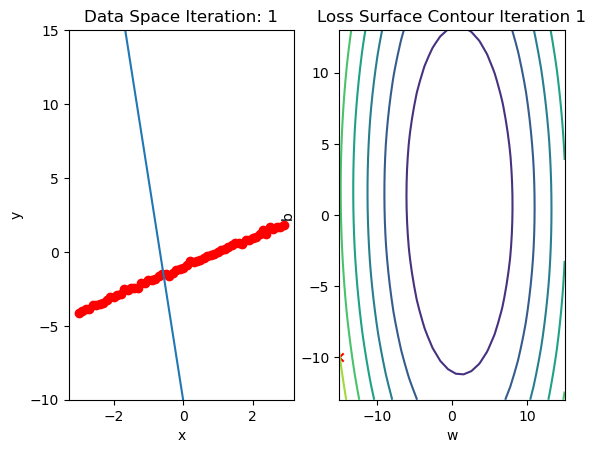

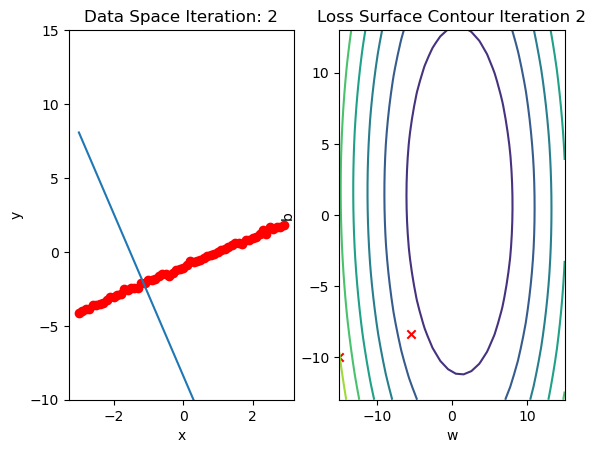

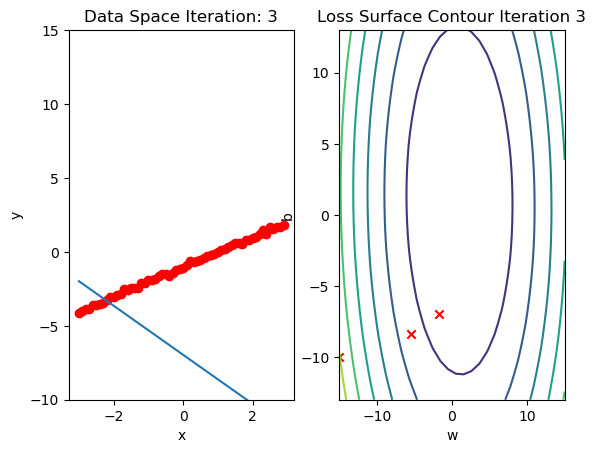

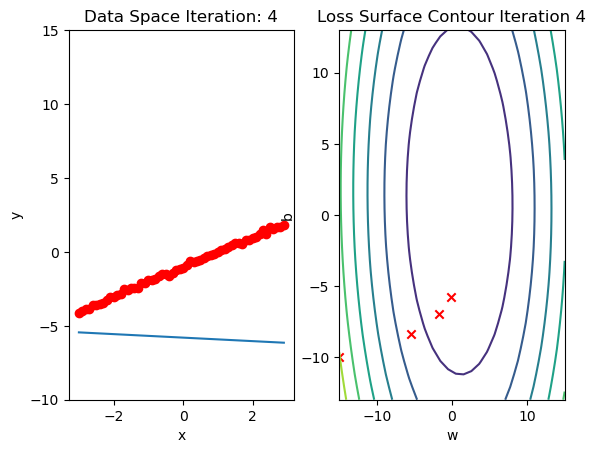

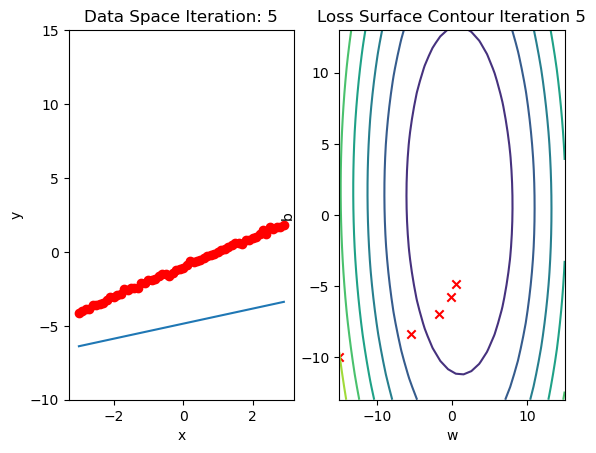

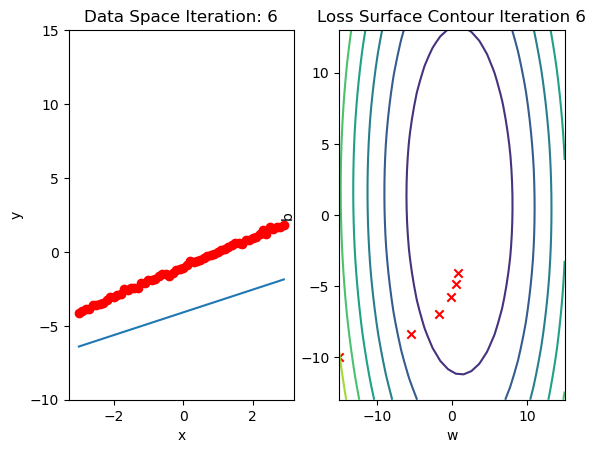

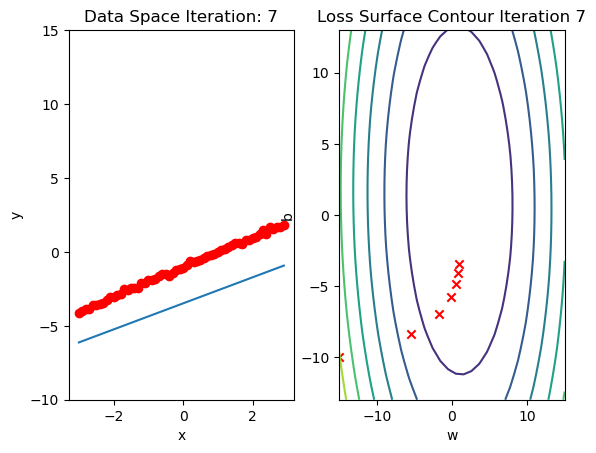

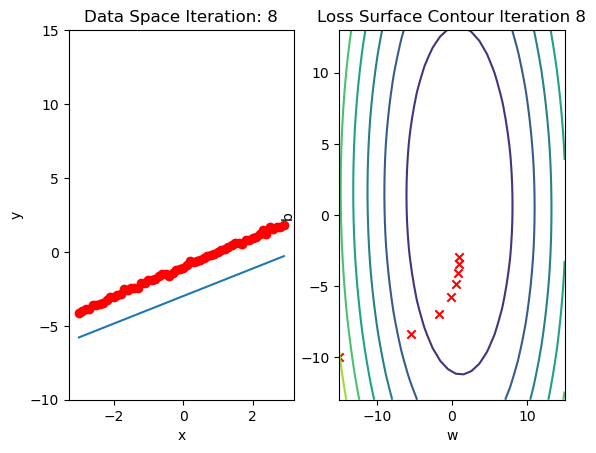

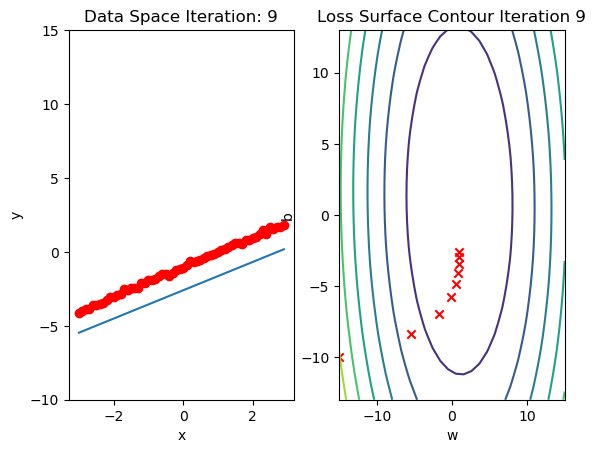

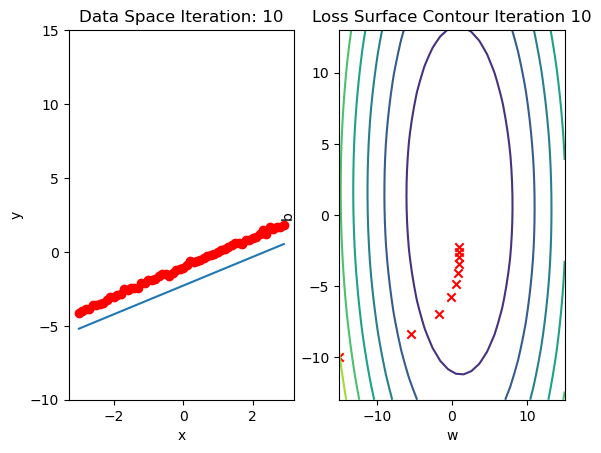

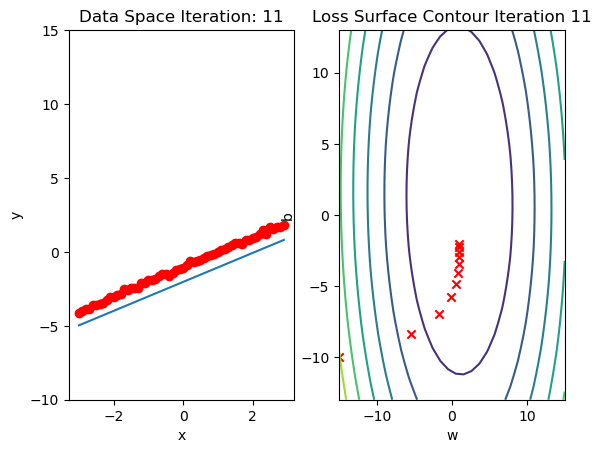

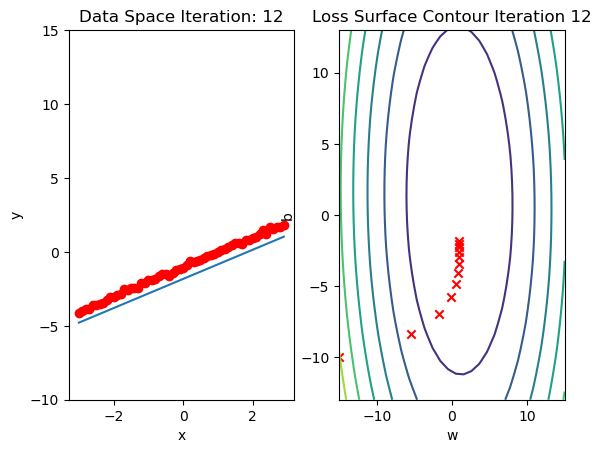

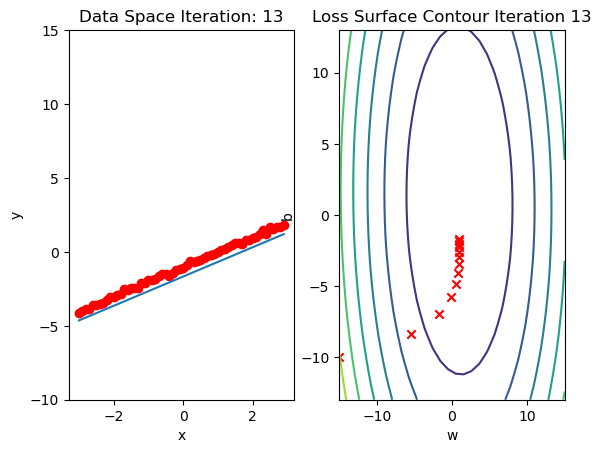

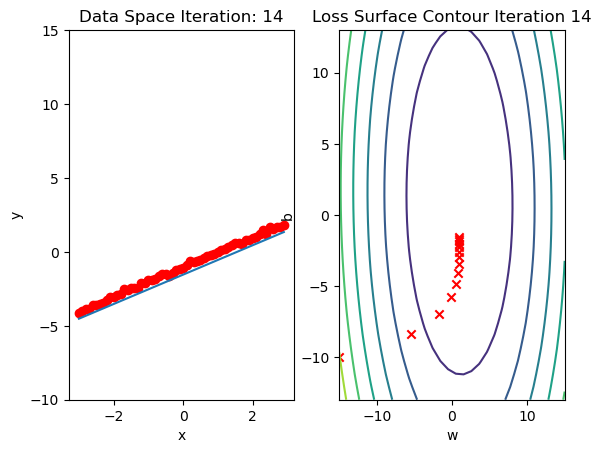

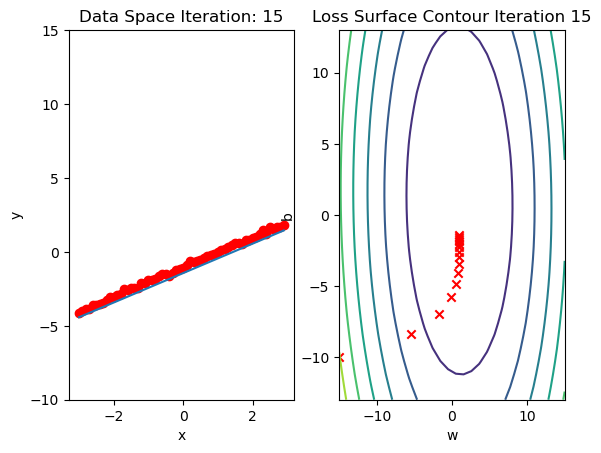

In [11]:
loss_bgd = train_model(15, X, y)

<a name="7"></a>
## <font color='blue'> <b> 7. Stochastic Gradient Descent </b> </font>

Stochastic Gradient Descent (SGD) updates model parameters using the gradient from a single randomly selected data point per iteration, making it faster but noisier than batch gradient descent

In [12]:
# Create plot_error_surfaces for viewing the data
get_surface = plot_error_surfaces(15, 13, X, y, 30, go = False)

In [16]:
# Función para entrenar el modelo
def train_model_SGD(iter, X, y, lr = 0.1):
    
    # initial values
    w = torch.tensor(-15.0, requires_grad = True)
    b = torch.tensor(-10.0, requires_grad = True)
    
    # to store results
    loss_sgd = []
    
    # Loop
    for epoch in range(iter):
        
        # SGD is an approximation of the total cost/loss. 
        # In this step, we calculate the cost/loss for each sample and store it.
        y_hat = forward(X, w, b) # len=60 (length of the dataset)
            # forward changes because of the update in the parameters w and b

        # loss (at dataset level)
        loss_sgd.append(criterion(y_hat, y).tolist())
        
        for x_, y_ in zip(X, y):
            
            # prediction
            yhat = forward(x_, w, b) # len=1 (1 sample)
        
            # loss
            loss = criterion(yhat, y_)

            # plots
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
            
            # backward pass
            loss.backward()
        
            # parameter updates
            w.data = w.data - lr * w.grad.data
            b.data = b.data - lr * b.grad.data

            # zero grad
            w.grad.data.zero_()
            b.grad.data.zero_()
            
        # plots after each epoch   
        get_surface.plot_ps()
        
    return loss_sgd

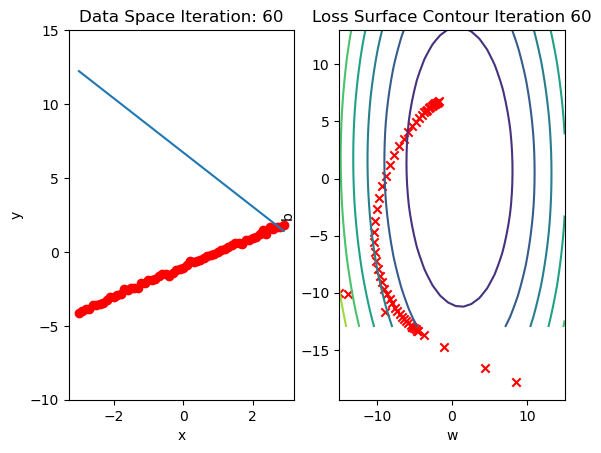

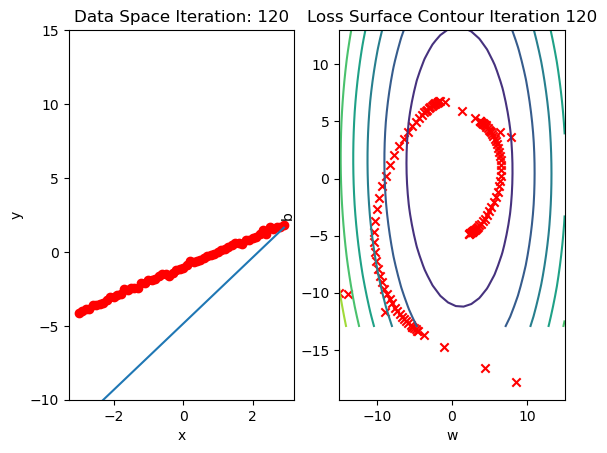

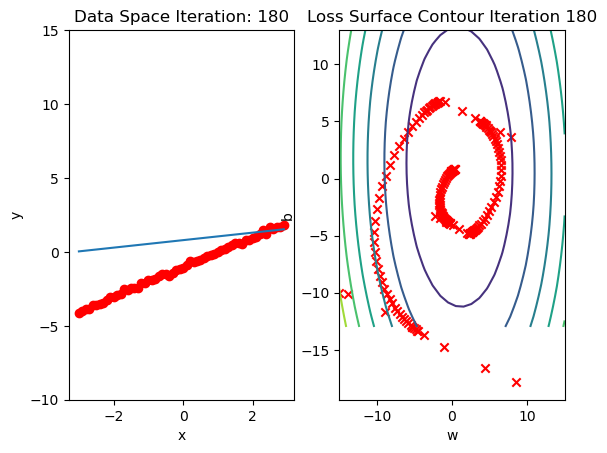

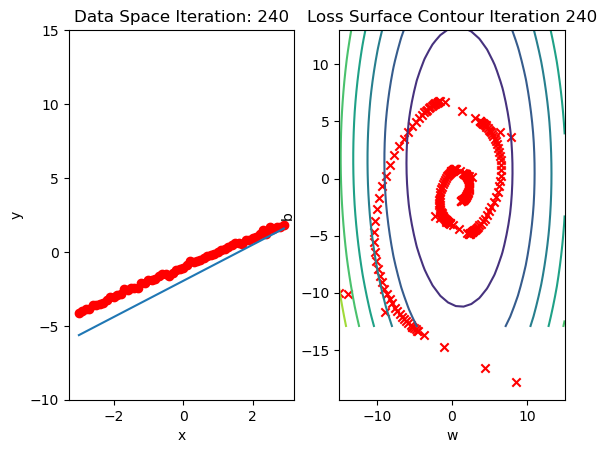

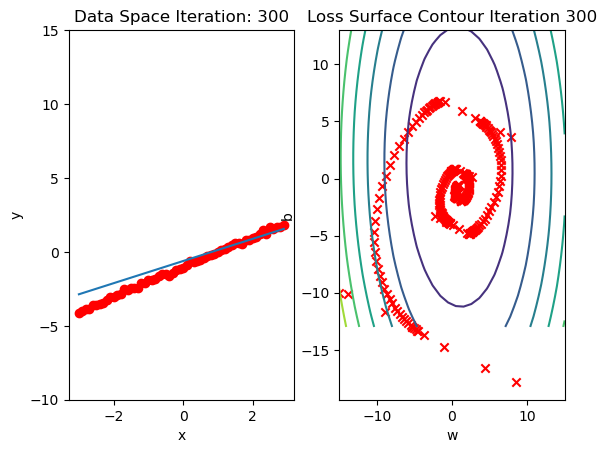

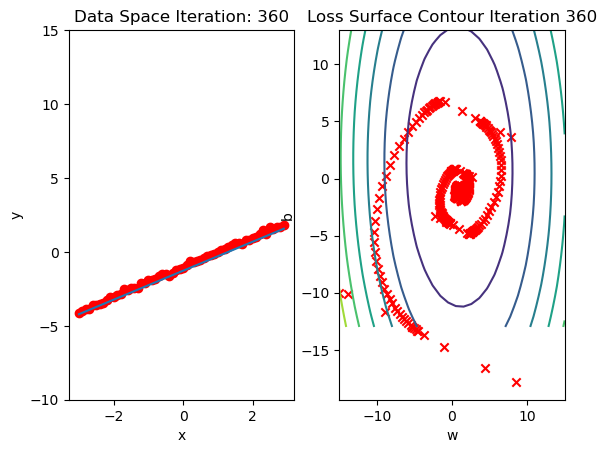

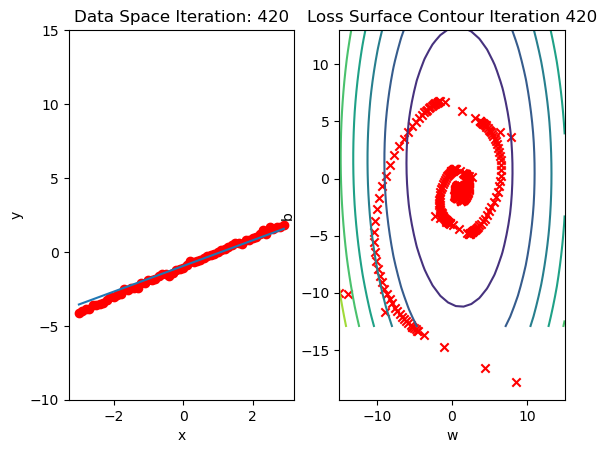

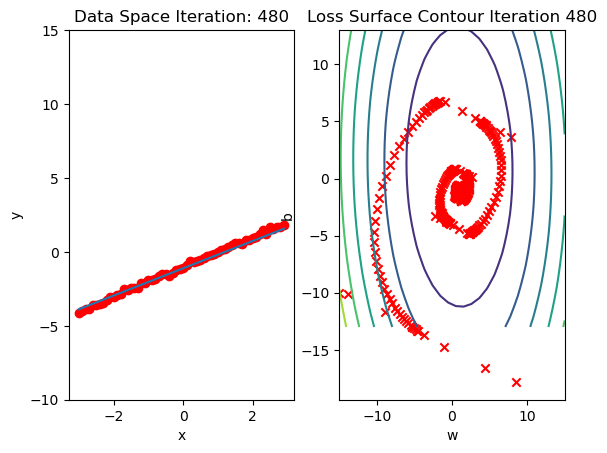

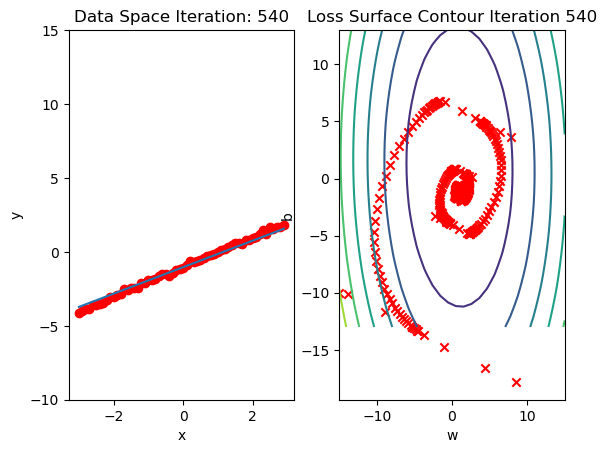

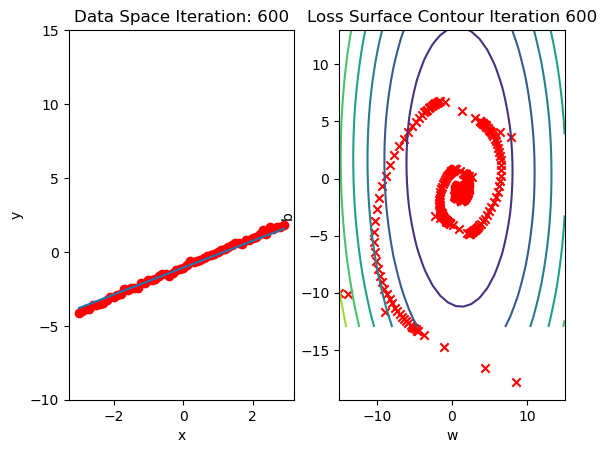

In [17]:
loss_sgd = train_model_SGD(10, X, y)

### SGD with Dataset DataLoader

In [18]:
# Import the library for DataLoader
from torch.utils.data import Dataset, DataLoader

In [19]:
# Dataset Class
class Data(Dataset):
    
    # constructor
    def __init__(self):
        self.x = torch.arange(-3, 3, 0.1).view(-1, 1)
        self.y = 1 * self.x - 1
        self.len = self.x.shape[0]

    # getter
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # return the length
    def __len__(self):
        return self.len


In [20]:
# Create the dataset and check the length
dataset = Data()
print("The length of dataset: ", len(dataset))

The length of dataset:  60


In [21]:
# Print the first 3 point
point_x, point_y = dataset[0:3]
print("The first 3 x: ", point_x)
print("The first 3 y: ", point_y)

The first 3 x:  tensor([[-3.0000],
        [-2.9000],
        [-2.8000]])
The first 3 y:  tensor([[-4.0000],
        [-3.9000],
        [-3.8000]])


In [22]:
# Create plot_error_surfaces for viewing the data
get_surface = plot_error_surfaces(15, 13, X, y, 30, go = False)

In [23]:
# Create DataLoader
trainloader = DataLoader(dataset = dataset, batch_size = 1)

In [24]:
# Función para entrenar el modelo
def train_model_data_loader(iter, trainloader, lr = 0.1):
    
    # initial values for the parameters
    w = torch.tensor(-15.0, requires_grad = True)
    b = torch.tensor(-10.0, requires_grad = True)
    
    # to store results
    loss_sgd = []
    
    # Loop
    for epoch in range(iter):
        
        # forward
        y_hat = forward(X, w, b)

        # loss (at dataset level)
        loss_sgd.append(criterion(y_hat, y).tolist())
        
        for x_, y_ in trainloader:
            
            # prediction
            yhat = forward(x_, w, b) # len=1 (1 sample)
        
            # loss
            loss = criterion(yhat, y_)

            # plots
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
            
            # backward pass
            loss.backward()
        
            # parameter updates
            w.data = w.data - lr * w.grad.data
            b.data = b.data - lr * b.grad.data

            # zero grad
            w.grad.data.zero_()
            b.grad.data.zero_()
            
        # plots after each epoch   
        get_surface.plot_ps()
        
    return loss_sgd

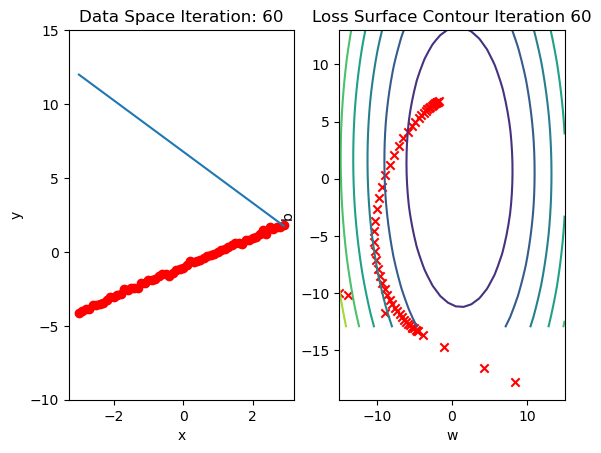

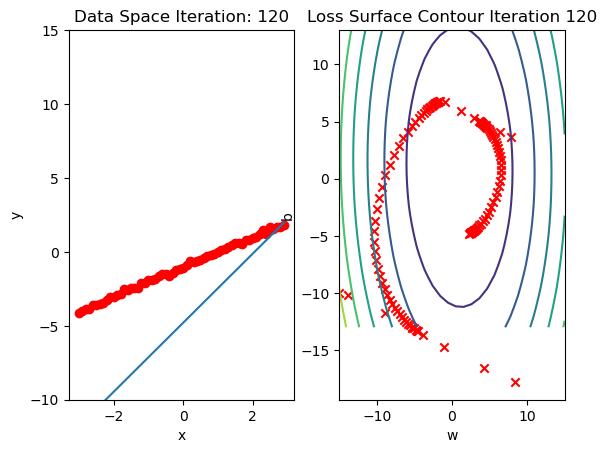

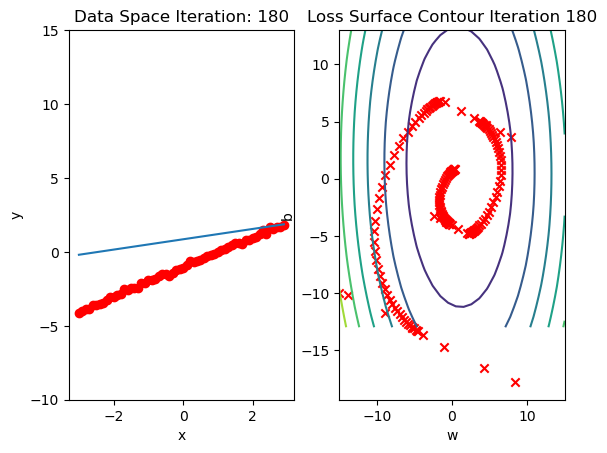

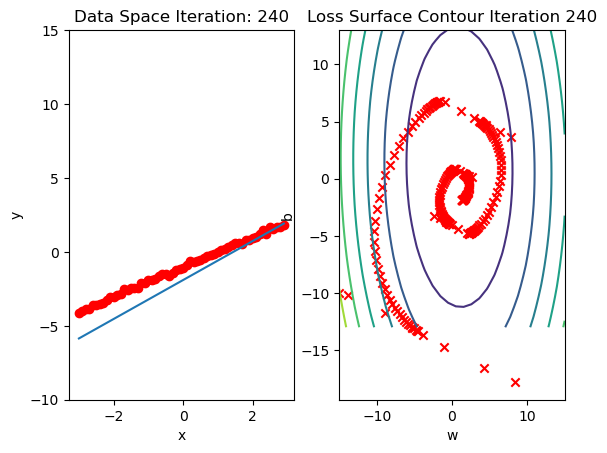

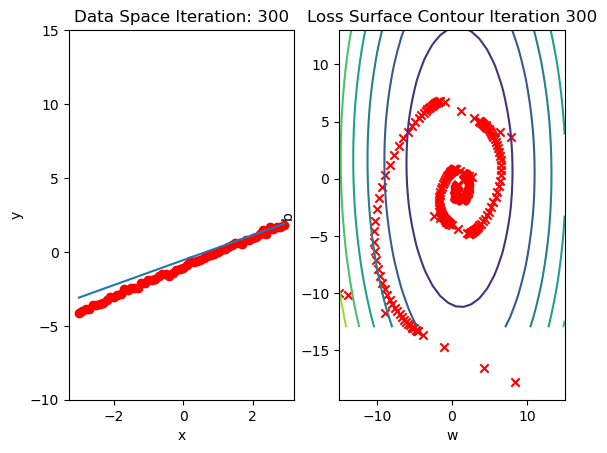

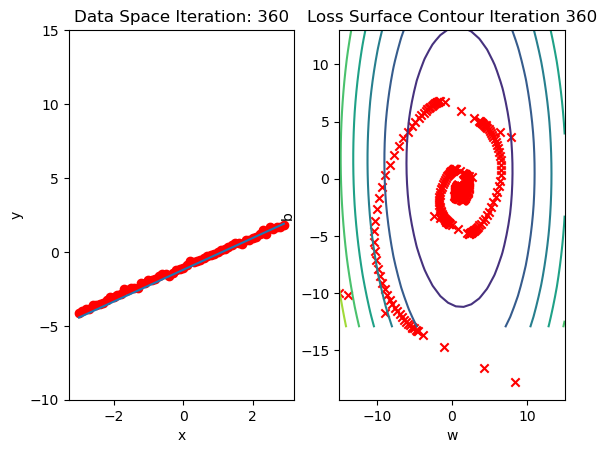

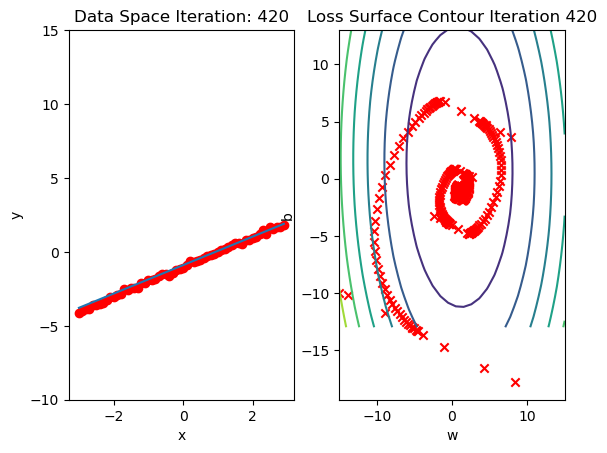

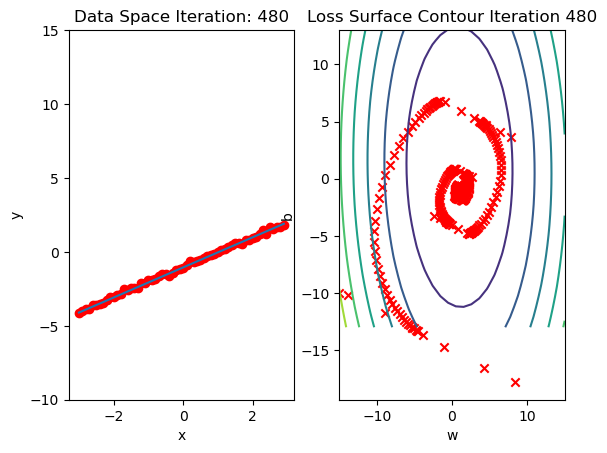

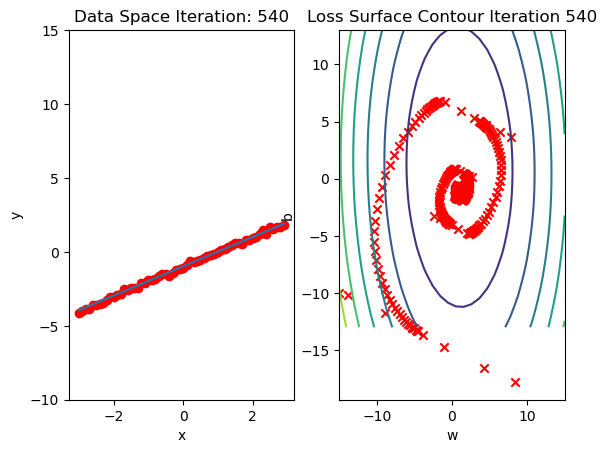

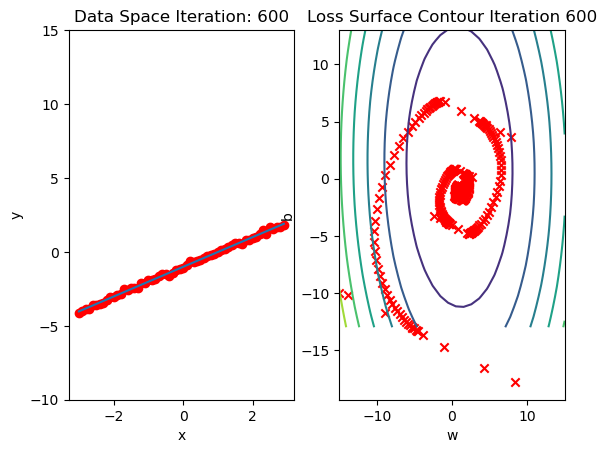

In [25]:
loss_sgd = train_model_data_loader(10, trainloader)

<a name="8"></a>
## <font color='blue'> <b> 8. Mini-Batch Gradient Descent </b> </font>

Mini-batch gradient descent is an optimization algorithm that updates the model's parameters using a small, randomly selected subset (mini-batch) of the training data, rather than the entire dataset (batch gradient descent) or just one data point (stochastic gradient descent). This approach balances the efficiency of batch processing with the noise reduction of stochastic updates.

In [28]:
# Create a plot_error_surfaces object.
get_surface = plot_error_surfaces(15, 13, X, y, 30, go = False)

In [29]:
# Create DataLoader object and Data object with batch_size = 5
dataset = Data()
trainloader = DataLoader(dataset = dataset, batch_size = 5)

In [41]:
w = torch.tensor(-15.0, requires_grad = True)
b = torch.tensor(-10.0, requires_grad = True)


Y = y

def train_model_mini_batch(epochs, trainloader, lr=0.1):
    
    loss_mb = []
    
    for epoch in range(epochs):
        Yhat = forward(X, w, b)
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), criterion(Yhat, Y).tolist())
        get_surface.plot_ps()
        loss_mb.append(criterion(forward(X, w, b), Y).tolist())
        for x, y in trainloader:
            yhat = forward(x, w, b)
            loss = criterion(yhat, y)
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
            loss.backward()
            w.data = w.data - lr * w.grad.data
            b.data = b.data - lr * b.grad.data
            w.grad.data.zero_()
            b.grad.data.zero_()
            
            
    return loss_mb

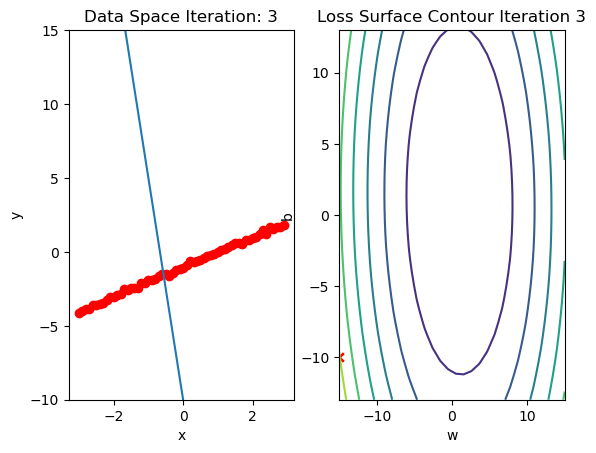

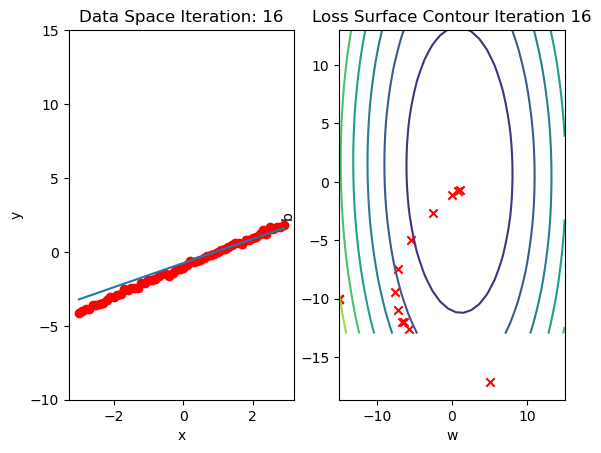

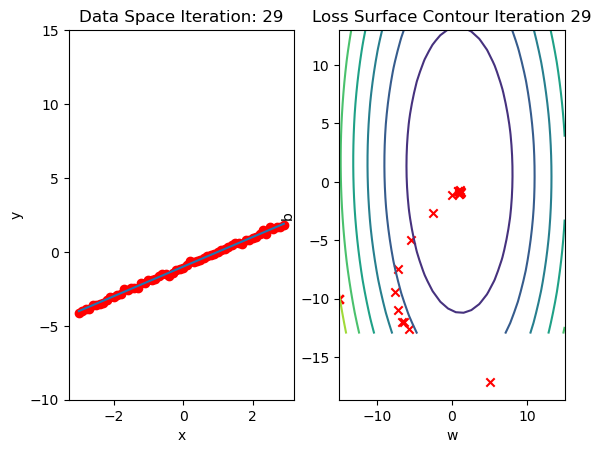

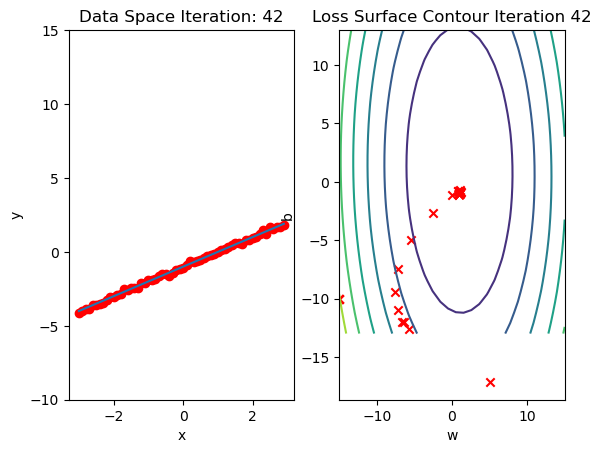

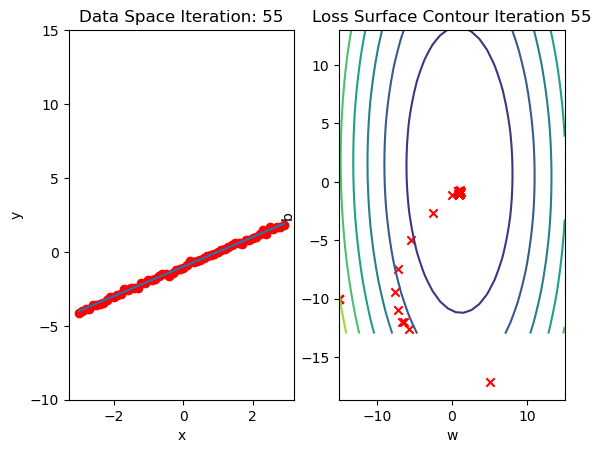

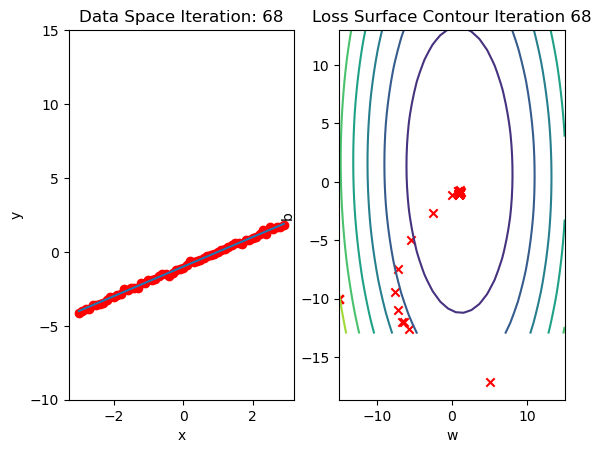

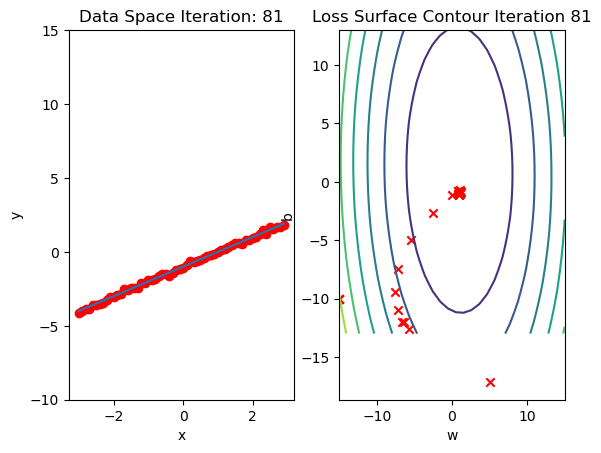

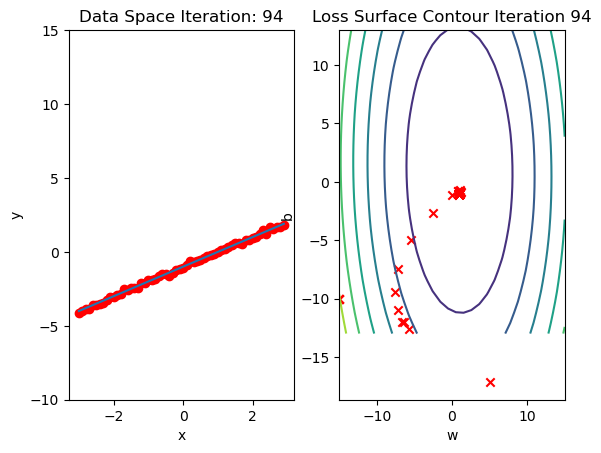

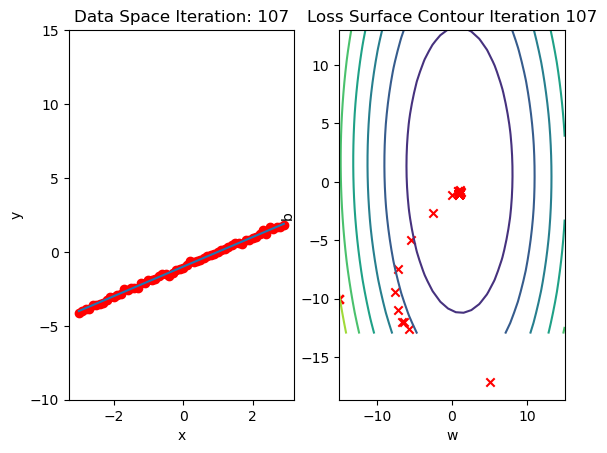

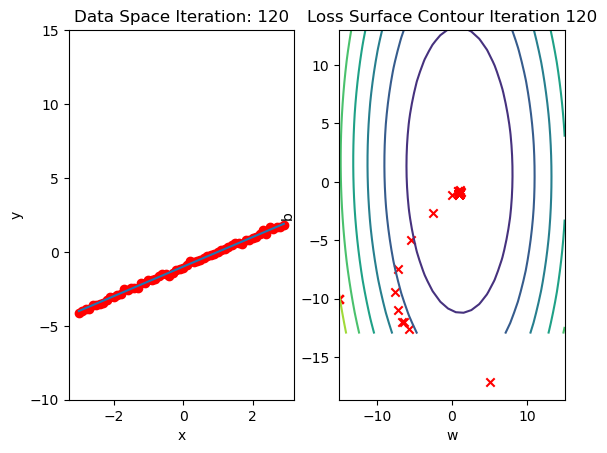

[835.276123046875,
 0.18780595064163208,
 0.008273560553789139,
 0.00833750981837511,
 0.008338185027241707,
 0.008338185027241707,
 0.008338185027241707,
 0.008338185027241707,
 0.008338185027241707,
 0.008338185027241707]

In [42]:
train_model_mini_batch(10, trainloader)

<a name="references"></a>
## <font color='blue'> <b> References </b> </font>

[IBM AI Engineering Professional Certificate](https://www.coursera.org/professional-certificates/ai-engineer)